# Airbnb Project

## Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import operator
from math import hypot
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

## Data Cleaning

#### Data Cleaning formulas we will use


In [2]:
properties = ['Apartment', 'House', 'Condomminium', 'Townhouse', 'Loft', 'Other']
def property_grouping(p):
    '''
    Given property type, if it is not an apartment, house, condo, townhouse, loft, or
    labeled as 'Other', set as 'Other'
    '''
    if p not in properties:
        p = 'Other'
    return p

def make_dummies(df):
    '''
    Take column of categories and make dummies in the dataset.
    Drop the original columns
    '''
    columns = list(df.columns)
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = df.join(dummies)
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.str.replace('/','_')
    df.columns = df.columns.str.replace('-', '_')
    df.drop(columns=columns,inplace=True)
    return df

#### Calculating Distance
There are 6 cities in the dataset. We are setting the coordinates for the downtown of each city.
Then we calculate the distance of each Airbnb from downtown.

In [3]:
lat_long = {'SF': {'lat': 37.7749, 'long': -122.4194},
            'Chicago': {'lat': 41.8781, 'long': -87.6298},
            'DC': {'lat': 38.9072, 'long': -77.0369},
            'LA': {'lat': 34.0522, 'long': -118.2437},
            'Boston': {'lat': 42.3601, 'long': -71.0589},
            'NYC': {'lat': 40.7128, 'long': -74.0060}}

def get_distance(row):
    '''
    Given a row of data, get the city, latitude, and longitude
    and calculate the distance from downtown.
    '''
    city = row['city']
    lat1 = lat_long[city]['lat']
    lat2 = row['latitude']
    long1 = lat_long[city]['long']
    long2 = row['longitude']
    lon = long1 - long2
    lat = lat1 - lat2
    a = (np.sin(lat/2))**2 + np.cos(lat1) * np.cos(lat2) * ((np.sin(lon/2))**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return 69.172*c

#### Cleaning up

In [50]:
#import data as dataframe
df = pd.read_csv('train.csv')
chi_df = df[df['city']=='Chicago']

In [6]:
#drop duplicates for Airbnb ID's and drop NA in specific columns
df.drop_duplicates(subset=['id'],inplace=True)
df.dropna(subset=['bathrooms', 'host_has_profile_pic',
                  'host_identity_verified', 'host_since',
                  'bedrooms', 'beds'],
                   inplace=True)

#create our distance column
df['distance'] = df.apply(lambda r: get_distance(r), axis=1)

#convert host response rates and review scores to floats between 0 and 1
df['host_response_rate'] = df['host_response_rate'].str.strip('%').astype('float')/100
df.review_scores_rating = df.review_scores_rating/100

#fill in empty host response rates and review scores as 0
df['host_response_rate'].fillna(value=0.0, inplace=True)
df['review_scores_rating'].fillna(value=0.0, inplace=True)

#Replace t,f and True,False to 1 and 0
df.replace({'t':1, 'f': 0}, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype(int)

#Apply a sqrt transform on number_of_reviews
df.number_of_reviews = df.number_of_reviews.apply(lambda x: np.sqrt(x))

In [7]:
#make a new columns of accommodates per bedroom
df['ppl_per_room'] = df['accommodates'] / df['bedrooms']

#replace inf and -inf with 0.0
df.ppl_per_room = df.ppl_per_room.replace([np.inf, -np.inf], float(0.0))

In [8]:
#Drop unwanted columns
df_cleaned = df.drop(columns = ['id','amenities', 'description',
                               'first_review', 'host_since', 'last_review',
                               'name', 'neighbourhood', 'thumbnail_url',
                               'zipcode', 'city', 'latitude', 'longitude', 'beds'])

In [9]:
#apply property_grouping function to property_type
df_cleaned['property_type'] = df_cleaned['property_type'].apply(property_grouping)

#get rid of any super strict policies since there are relatively a few of them
df_cleaned = df_cleaned[df_cleaned['cancellation_policy'].str.contains('super')==False]

In [11]:
#Rearranging the dataframe
B = df_cleaned.select_dtypes(exclude='object')
A = df_cleaned[['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified','instant_bookable']]
B = B.drop(columns=list(A.columns))
C = df_cleaned.select_dtypes(include='object')

In [12]:
#Our finalized dataframe that we will work with
final_df = A.join(C)
final_df = final_df.join(B)

In [14]:
#some encoding
dummies = make_dummies(final_df.iloc[:,4:8])
final_df = final_df.join(dummies)
final_df.drop(columns=['property_type', 'room_type', 'bed_type', 'cancellation_policy'], inplace=True)

In [16]:
#set our dependent variable separately from the independent variables
y = final_df.log_price
final_df.drop(columns='log_price',inplace=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(final_df, y, test_size=.3)

# Analysis

## Run our model on our train data

We are setting our categorical and numeric data separately. Our extra is composed of columns with binary values.

In [19]:
X_numeric_train = X_train.iloc[:,4:12]
X_categorical_train = X_train.iloc[:,12:]
X_extra_train = X_train.iloc[:,:4]

Scaling our data for a more direct compmarison and maintain our columns and index values

In [20]:
ss = StandardScaler()

X_num_train_col = X_numeric_train.columns
X_num_train_ind = X_numeric_train.index

X_numeric_train = pd.DataFrame(ss.fit_transform(X_numeric_train))

X_numeric_train.columns = X_num_train_col
X_numeric_train.index = X_num_train_ind

Drop our outliers and make sure the indices are the same over all the dataframes

In [62]:
X_numeric_train = X_numeric_train[(np.abs(X_numeric_train) < 2.5).all(axis=1)]

X_categorical_train = X_categorical_train[X_categorical_train.index.isin(X_numeric_train.index)]
X_extra_train = X_extra_train[X_extra_train.index.isin(X_numeric_train.index)]
y_train = y_train[y_train.index.isin(X_numeric_train.index)]

Put our entire dataframe back together.

In [63]:
X1 = X_numeric_train.join(X_categorical_train)
X1 = X1.join(X_extra_train)

### Baseline
Getting rid of the dummy trap by setting our baseline as having an entire Apartment with a real bed and moderate rule policies. Then we see what our score is.

In [64]:
X1.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)
lr = LinearRegression()
lr.fit(X1,y_train)
lr.score(X1,y_train)

0.49892612256502183

# Test Data

Rerun our model on our test data.

In [66]:
X_numeric_test = X_test.iloc[:,7:12]
X_categorical_test = X_test.iloc[:,12:]
X_extra_test = X_test.iloc[:,:3]

ss = StandardScaler()

X_num_test_col = X_numeric_test.columns
X_num_test_ind = X_numeric_test.index

X_numeric_test = pd.DataFrame(ss.fit_transform(X_numeric_test))

X_numeric_test.columns = X_num_test_col
X_numeric_test.index = X_num_test_ind

X_numeric_test = X_numeric_test[(np.abs(X_numeric_test) < 2.5).all(axis=1)]

X_categorical_test = X_categorical_test[X_categorical_test.index.isin(X_numeric_test.index)]
X_extra_test = X_extra_test[X_extra_test.index.isin(X_numeric_test.index)]
y_test = y_test[y_test.index.isin(X_numeric_test.index)]

X2 = X_numeric_test.join(X_categorical_test)
X2 = X2.join(X_extra_test)

X2.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

Check our score for our test data.

In [67]:
lr = LinearRegression()
lr.fit(X2,y_test)
lr.score(X2,y_test)

0.4915476109469443

#### Train Data Model

In [27]:
X1.drop(columns=['ppl_per_room','Townhouse', 'Airbed', 'Couch', 'Pull_out_Sofa', 'flexible', 'host_identity_verified'])
f1 = 'log_price ~ ' + '+'.join(X1.columns)
mod = smf.ols(formula=f1, data = X1.join(y_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     1896.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:03:40   Log-Likelihood:                -30552.
No. Observations:               45733   AIC:                         6.115e+04
Df Residuals:                   45708   BIC:                         6.137e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.1655      0.041    125.210      0.000       5.085       5.246
accommodates               0.2037      0.006     36.691      0.000       0.193       0.215
bathrooms                  0.0837      0.004     20.846      0.000       0.076       0.092
host_response_rate        -0.0326      0.003    -12.728      0.000      -0.038      -0.028
number_of_reviews         -0.0162      0.003     -4.801      0.000      -0.023      -0.010
review_scores_rating      -0.0590      0.003    -21.123      0.000      -0.065      -0.054
bedrooms                   0.0951      0.004     23.379      0.000       0.087       0.103
distance                  -0.1421      0.003    -47.722      0.000      -0.148      -0.136
ppl_per_room              -0.0104      0.003     -3.402      0.001      -0.016      -0.004
House                      0.0144      0.006      2.357      0.018       0.002       0.026
Loft                       0.1349      0.017      7.769      0.000       0.101       0.169
Other                      0.1136      0.009     12.968      0.000       0.096       0.131
Townhouse                  0.0351      0.015      2.281      0.023       0.005       0.065
Private_room              -0.5543      0.006    -95.637      0.000      -0.566      -0.543
Shared_room               -0.9821      0.015    -66.863      0.000      -1.011      -0.953
Airbed                    -0.0466      0.027     -1.700      0.089      -0.100       0.007
Couch                      0.0362      0.037      0.989      0.323      -0.036       0.108
Futon                     -0.0504      0.022     -2.323      0.020      -0.093      -0.008
Pull_out_Sofa              0.0194      0.025      0.773      0.439      -0.030       0.069
flexible                   0.0005      0.006      0.077      0.938      -0.012       0.013
strict                     0.0374      0.006      6.748      0.000       0.027       0.048
cleaning_fee              -0.0286      0.006     -5.150      0.000      -0.039      -0.018
host_has_profile_pic      -0.1221      0.041     -2.991      0.003      -0.202      -0.042
host_identity_verified    -0.0067      0.005     -1.364      0.172      -0.016       0.003
instant_bookable          -0.0521      0.005    -10.042      0.000      -0.062      -0.042
==============================================================================
Omnibus:                     4393.526   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12749.266
Skew:                           0.524   Prob(JB):                         0.00
Kurtosis:                       5.365   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

#### Test Data Model

In [68]:
X2.drop(columns=['Couch', 'Pull_out_Sofa', 'flexible', 'host_has_profile_pic', 'host_identity_verified', 'Airbed'],inplace=True)
f2 = 'log_price ~ ' + '+'.join(X2.columns)
mod = smf.ols(formula=f2, data = X2.join(y_test))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     1380.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:38:54   Log-Likelihood:                -13918.
No. Observations:               20019   AIC:                         2.787e+04
Df Residuals:                   20004   BIC:                         2.798e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.0530      0.009    577.634      0.000       5.036       5.070
number_of_reviews       -0.0322      0.005     -6.485      0.000      -0.042      -0.022
review_scores_rating    -0.0674      0.004    -16.009      0.000      -0.076      -0.059
bedrooms                 0.2228      0.005     46.013      0.000       0.213       0.232
distance                -0.1350      0.005    -29.606      0.000      -0.144      -0.126
ppl_per_room             0.0286      0.004      6.623      0.000       0.020       0.037
House                    0.0534      0.009      5.752      0.000       0.035       0.072
Loft                     0.2233      0.027      8.324      0.000       0.171       0.276
Other                    0.1696      0.013     12.928      0.000       0.144       0.195
Townhouse                0.0402      0.025      1.633      0.102      -0.008       0.088
Private_room            -0.6966      0.008    -92.210      0.000      -0.711      -0.682
Shared_room             -1.1489      0.020    -56.128      0.000      -1.189      -1.109
Futon                   -0.0864      0.034     -2.513      0.012      -0.154      -0.019
strict                   0.0378      0.007      5.178      0.000       0.024       0.052
cleaning_fee            -0.0158      0.008     -1.882      0.060      -0.032       0.001
==============================================================================
Omnibus:                     1801.044   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4270.895
Skew:                           0.549   Prob(JB):                         0.00
Kurtosis:                       4.978   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Model

Run our model on our entire dataset.

In [29]:
X_numeric = final_df.iloc[:,7:12]
X_categorical = final_df.iloc[:,12:]
X_extra = final_df.iloc[:,:3]

ss = StandardScaler()

X_num_col = X_numeric.columns
X_num_ind = X_numeric.index

X_numeric = pd.DataFrame(ss.fit_transform(X_numeric))

X_numeric.columns = X_num_col
X_numeric.index = X_num_ind

X_numeric = X_numeric[(np.abs(X_numeric) < 2.5).all(axis=1)]

X_categorical = X_categorical[X_categorical.index.isin(X_numeric.index)]
X_extra = X_extra[X_extra.index.isin(X_numeric.index)]
y = y[y.index.isin(X_numeric.index)]

X = X_numeric.join(X_categorical)
X = X.join(X_extra)

X.drop(columns=['Apartment', 'Entire_home_apt', 'Real_Bed', 'moderate'],inplace=True)

lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.48681462259074426

Get our coefficients and sort them

In [69]:
coefficients = dict(zip(X.columns,lr.coef_))
coefficients = sorted(coefficients.items(), key=(lambda c:c[1]), reverse=True)

Get our model and its summary for our entire data.

In [33]:
X.drop(columns=['Airbed', 'Pull_out_Sofa', 'flexible', 'host_identity_verified'],inplace=True)
f = 'log_price ~ ' + '+'.join(X.columns)
mod = smf.ols(formula=f, data = X.join(y))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     3956.
Date:                Fri, 06 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:03:41   Log-Likelihood:                -46962.
No. Observations:               66760   AIC:                         9.396e+04
Df Residuals:                   66743   BIC:                         9.411e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.1922      0.034    150.821      0.000       5.125       5.260
number_of_reviews       -0.0268      0.003     -9.715      0.000      -0.032      -0.021
review_scores_rating    -0.0684      0.002    -29.323      0.000      -0.073      -0.064
bedrooms                 0.2259      0.003     84.537      0.000       0.221       0.231
distance                -0.1372      0.003    -54.204      0.000      -0.142      -0.132
ppl_per_room             0.0278      0.002     11.923      0.000       0.023       0.032
House                    0.0508      0.005      9.877      0.000       0.041       0.061
Loft                     0.1936      0.015     13.094      0.000       0.165       0.223
Other                    0.1364      0.007     18.506      0.000       0.122       0.151
Townhouse                0.0628      0.013      4.810      0.000       0.037       0.088
Private_room            -0.6935      0.004   -166.911      0.000      -0.702      -0.685
Shared_room             -1.1634      0.012    -98.731      0.000      -1.186      -1.140
Couch                    0.0779      0.032      2.468      0.014       0.016       0.140
Futon                   -0.0581      0.019     -3.086      0.002      -0.095      -0.021
strict                   0.0429      0.004     10.646      0.000       0.035       0.051
cleaning_fee            -0.0261      0.005     -5.655      0.000      -0.035      -0.017
host_has_profile_pic    -0.1332      0.034     -3.887      0.000      -0.200      -0.066
==============================================================================
Omnibus:                     6265.145   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16423.742
Skew:                           0.542   Prob(JB):                         0.00
Kurtosis:                       5.174   Cond. No.                         44.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualizations

In [34]:
final_df
actual_prices = y.apply(lambda Y: np.exp(Y))

0        150.0
1        169.0
2        145.0
3        750.0
4        115.0
         ...  
74105     70.0
74106    100.0
74107    155.0
74108    185.0
74109    195.0
Name: log_price, Length: 66760, dtype: float64

In [35]:
df_vis = final_df.join(actual_prices)

In [37]:
num_people = df['accommodates'].unique()

In [38]:
num_people = sorted(num_people)

In [42]:
probability = []
group_probabilities = []
responses = []
rooms = []
distances = []
per_room = []
prices = []
bathrooms = []
for n in num_people:
    temp_df = df_vis[df_vis['accommodates'] == n]
    n_y = list(temp_df['instant_bookable'].value_counts())
    
    group_p = len(temp_df['accommodates'])/len(final_df['accommodates'])
    response_mean = np.mean(temp_df['host_response_rate'])
    room_mean = np.mean(temp_df['bedrooms'])
    distance_mean = np.mean(temp_df['distance'])
    ppl = np.mean(temp_df['ppl_per_room'])
    price = np.mean(temp_df['log_price'])
    bathroom = np.mean(temp_df['bathrooms'])
    
    group_probabilities.append(group_p)
    responses.append(response_mean)
    probability.append(n_y[1]/sum(n_y))
    rooms.append(room_mean)
    distances.append(distance_mean)
    per_room.append(ppl)
    prices.append(price)
    bathrooms.append(bathroom)


### Fix

In [43]:
chi_distances = [4.535114338084559,
                4.152032033317386,
                3.6008852645078613,
                3.6241075139931658,
                3.380424440005781,
                3.7191416795433465,
                3.759474050859176,
                4.036074919146024,
                4.520354086707857,
                3.3944474563658797,
                3.139857108008428,
                3.858627542973955,
                3.669589482591857,
                4.1642599672180065,
                5.559858725178525,
                3.130400965979456]

Clarify graphs and axis more
'Seems like Chicago makes most of the data'

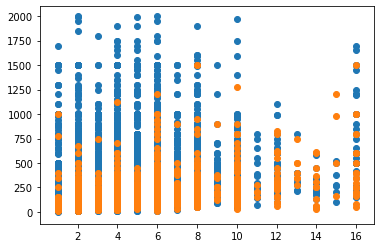

In [55]:
plt.scatter(df_vis['accommodates'],df_vis['log_price'])
plt.scatter(chi_df['accommodates'],np.exp(chi_df['log_price']))

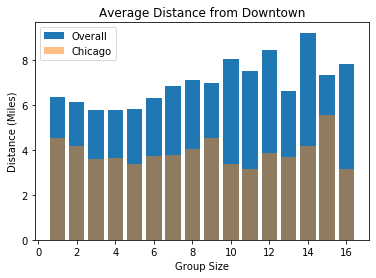

In [44]:

plt.bar(num_people,distances)
plt.bar(num_people, chi_distances, alpha=.5)
plt.title('Average Distance from Downtown')
plt.xlabel('Group Size')
plt.ylabel('Distance (Miles)')
plt.legend(['Overall', 'Chicago'])
plt.savefig('images/distance.png')
plt.show();

* Chicago info
* equal time on graphs

In [45]:
chi_prices = [62.85652173913044,
             83.02415812591508,
             111.99675324675324,
             137.48458149779736,
             163.38425925925927,
             209.43304843304844,
             211.11320754716985,
             224.08130081300817,
             287.18181818181824,
             252.46153846153842,
             198.99999999999997,
             303.83333333333326,
             337.0000000000002,
             292.50000000000006,
             0.0,
             481.1111111111108]

In [47]:
chi_probability = [0.06470746832030197,
                   0.3817740630897816,
                   0.08627662442706929,
                   0.19034780264222162,
                   0.06093286600161769,
                   0.11081153949851712,
                   0.0159072526287409,
                   0.04259908331086546,
                   0.004044216770018873,
                   0.022377999460771097,
                   0.0010784578053383662,
                   0.0067403612833647885,
                   0.0018873011593421407,
                   0.0032353734160150984,
                   0.0010784578053383662,
                   0.006201132380695605]

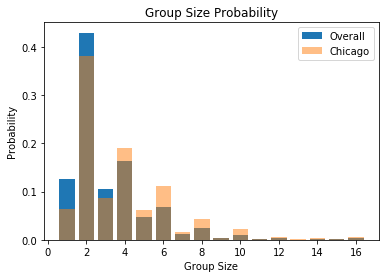

In [48]:
plt.bar(num_people, group_probabilities)
plt.bar(num_people, chi_probability, alpha=0.5)
plt.title('Group Size Probability')
plt.xlabel('Group Size')
plt.ylabel('Probability')
plt.legend(['Overall', 'Chicago'])
plt.savefig('images/group_size_p.png')
plt.show();

In [49]:
np.mean(df_vis['log_price'])

150.43873576992212